<a href="https://colab.research.google.com/github/kangeroo-123/proj0-api-biz-eda/blob/IBA_NEW_C%ED%8C%80/ICB_%EB%B0%95%ED%83%9C%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install requests pandas matplotlib seaborn


In [47]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime


In [48]:
def get_naver_data(query, start_date, end_date, start_month, end_month):
    url = f'https://openapi.naver.com/v1/datalab/search'
    headers = {
        'X-Naver-Client-Id': '',  # Client ID
        'X-Naver-Client-Secret': '',  # Secret Code
    }

    # 요청 데이터
    data = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "month",  # 월별 단위
        "keywordGroups": [{"groupName": query, "keywords": [query]}],
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    response_data = response.json()

    # 데이터 파싱
    trend_data = response_data['results'][0]['data']
    dates = [item['period'] for item in trend_data]
    values = [item['ratio'] for item in trend_data]

    # DataFrame으로 변환
    df = pd.DataFrame({
        'Date': pd.to_datetime(dates),
        'Trend': values
    })

    return df


In [64]:
# 데이터 수집
start_date = "2023-01-01"
end_date = "2024-12-01"

# 각 복종에 대해 데이터 수집
knit_data = get_naver_data('니트', start_date, end_date, '01', '12')
sweatshirt_data = get_naver_data('맨투맨', start_date, end_date, '01', '12')
hoodie_data = get_naver_data('후드', start_date, end_date, '01', '12')

# 데이터 결합
df_all = pd.merge(knit_data, sweatshirt_data, on='Date', how='outer', suffixes=('_니트', '_맨투맨'))
df_all = pd.merge(df_all, hoodie_data, on='Date', how='outer')
df_all = df_all.rename(columns={'Trend': '후드'})

# 결측치 처리 (선형 보간법)
df_all = df_all.interpolate(method='linear', axis=0)

# 시계열 데이터로 Date를 인덱스로 설정
df_all.set_index('Date', inplace=True)

# 데이터 미리보기
df_all.head()


,Trend_니트,Trend_맨투맨,후드
Date,,,
2023-01-01,84.41834,57.59704,75.64293
2023-02-01,64.41154,56.65589,73.83584
2023-03-01,52.10496,76.21178,66.91391
2023-04-01,31.25653,47.48008,54.26714
2023-05-01,21.13420,19.57298,48.41628


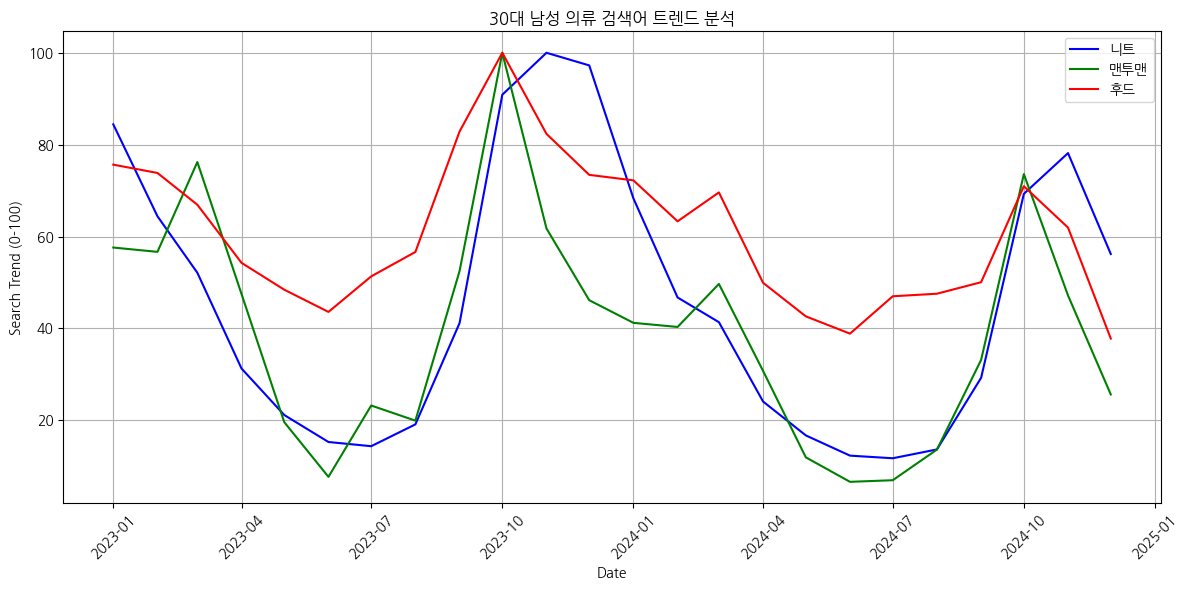

In [62]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x=df_all.index, y='Trend_니트', label='니트', color='blue')
sns.lineplot(data=df_all, x=df_all.index, y='Trend_맨투맨', label='맨투맨', color='green')
sns.lineplot(data=df_all, x=df_all.index, y='후드', label='후드', color='red')

plt.title('30대 남성 의류 검색어 트렌드 분석')
plt.xlabel('Date')
plt.ylabel('Search Trend (0-100)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [68]:
# 컬럼명 변경: 'Trend_'를 제거
df_all.columns = df_all.columns.str.replace('Trend_', '')

# 최근 6개월 데이터
recent_trends = df_all.tail(6)

# 평균 변화량 계산
average_increase = recent_trends.diff().mean()

# 25년도 예상 값 예측
forecast_25 = df_all.iloc[-1] + average_increase

# 예측 결과를 명확하게 표시하기 위해 컬럼명을 df_all.columns로 설정
forecast_25.index = df_all.columns

# 2번째 열의 이름을 '25년도 예상 값'으로 변경
forecast_25.name = '25년도 예상 값'

forecast_25


,25년도 예상 값
니트,65.083634
맨투맨,29.343930
후드,35.935612
